In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import edge_sim_py as espy
import networkx as nx
import random
import copy
import espydeps.helper_methods as helper

In [2]:
headers = [
    "Radio",  # The generation of broadband cellular network technology (Eg. LTE, GSM)
    "MCC",  # Mobile country code. This info is publicly shared by International Telecommunication Union (link)
    "MNC",  # Mobile network code. This info is publicly shared by International Telecommunication Union (link)
    "LAC/TAC/NID",  # Location Area Code
    "CID",  # This is a unique number used to identify each Base transceiver station or sector of BTS
    "Changeable=0",  # The location is directly obtained from the telecom firm
    "Longitude",  # Longitude, is a geographic coordinate that specifies the east-west position of a point on the Earth's surface
    "Latitude",  # Latitude is a geographic coordinate that specifies the north–south position of a point on the Earth's surface.
    "Range",  # Approximate area within which the cell could be. (In meters)
    "Samples",  # Number of measures processed to get a particular data point
    "Changeable=1",  # The location is determined by processing samples
    "Created",  # When a particular cell was first added to database (UNIX timestamp)
    "Updated",  # When a particular cell was last seen (UNIX timestamp)
    "AverageSignal",  # To get the positions of cells, OpenCelliD processes measurements from data contributors. Each measurement includes GPS location of device + Scanned cell identifier (MCC-MNC-LAC-CID) + Other device properties (Signal strength). In this process, signal strength of the device is averaged. Most ‘averageSignal’ values are 0 because OpenCelliD simply didn’t receive signal strength values.
]
df_og = pd.read_csv("../datasets/geo-dataset-724.csv", names=headers)  # , usecols=[4, 6, 7, 8])
# df_og

In [3]:
# ---------------
# | 0,0       0,1
# |
# | 1,0       1,1
# ---------------
# Latitude, Longitude (x, y)
# ---------------
# | +1,-1   +1,+0   +1,+1
# |
# | +0,-1   +0,+0   +1,+0
# |
# | -1,-1   -1,+0   +1,-1
# ---------------
# São Paulo
coord_start = { "Latitude": -23.438893, "Longitude": -46.324440 }
coord_final = { "Latitude": -23.814428, "Longitude": -46.911431 }

# Joinville
coord_start = { "Latitude": -26.200431, "Longitude": -48.748822 }
coord_final = { "Latitude": -26.376193, "Longitude": -48.945546 }

df = df_og.copy()

df = df.loc[df.Latitude <= coord_start["Latitude"]]
df = df.loc[df.Longitude <= coord_start["Longitude"]]

df = df.loc[df.Latitude >= coord_final["Latitude"]]
df = df.loc[df.Longitude >= coord_final["Longitude"]]

df = df.reset_index(drop=True)
# df

In [27]:
# Points of interest
pis = []
pis_header = ['Latitude',       'Longitude',     'PeakStart', 'PeakEnd', 'Name']
pis.append([-26.263246003308190, -48.861225375722130,   7.5,  17.5, 'Doller'                ])
pis.append([-26.252990373029380, -48.854708408036230,     8,    17, 'UDESC'                 ])
pis.append([-26.319269027247838, -48.855449473777610,    18,  22.5, 'Unisociesc'            ])
pis.append([-26.301289513710334, -48.844462116106380,     6,     8, 'Terminal_Centro_Manha' ])
pis.append([-26.301289513710334, -48.844462116106380,    17,    19, 'Terminal_Centro_Tarde' ])
pis.append([-26.273045033616377, -48.850776060285575,     6,     8, 'Terminal_Norte_Manha'  ])
pis.append([-26.273045033616377, -48.850776060285575,    17,    19, 'Terminal_Norte_Tarde'  ])
pis.append([-26.288328365610113, -48.810846717956740,     8,    17, 'Tupy'                  ])
pis.append([-26.303556261544664, -48.848987585420980,    18,    23, 'Shopping_Muller'       ])
pis.append([-26.252303610588786, -48.852610343093396,    18,    23, 'Shopping_Garten'       ])
pis_data = {
    pis_header[0]: [pi[0] for pi in pis],
    pis_header[1]: [pi[1] for pi in pis],
    pis_header[2]: [pi[2] for pi in pis],
    pis_header[3]: [pi[3] for pi in pis],
    pis_header[4]: [pi[4] for pi in pis],
}

df_pis = pd.DataFrame(data=pis_data)
df_pis

,Latitude,Longitude,PeakStart,PeakEnd,Name
0,-26.263246,-48.861225,7.5,17.5,Doller
1,-26.252990,-48.854708,8.0,17.0,UDESC
2,-26.319269,-48.855449,18.0,22.5,Unisociesc
3,-26.301290,-48.844462,6.0,8.0,Terminal_Centro_Manha
4,-26.301290,-48.844462,17.0,19.0,Terminal_Centro_Tarde
5,-26.273045,-48.850776,6.0,8.0,Terminal_Norte_Manha
6,-26.273045,-48.850776,17.0,19.0,Terminal_Norte_Tarde
7,-26.288328,-48.810847,8.0,17.0,Tupy
8,-26.303556,-48.848988,18.0,23.0,Shopping_Muller
9,-26.252304,-48.852610,18.0,23.0,Shopping_Garten


In [31]:
df_norm = df.copy()
lower, upper = 0, 100

# TODO normalize using coord_start and coord_end of joinville
lat_min, lat_max = df_norm.Latitude.min(), df_norm.Latitude.max()
df_norm.Latitude = (df_norm.Latitude - lat_min) / (lat_max - lat_min) * (upper - lower) + lower
df_norm.Latitude = df_norm.Latitude.astype(np.int64)

lon_min, lon_max = df_norm.Longitude.min(), df_norm.Longitude.max()
df_norm.Longitude = (df_norm.Longitude - lon_min) / (lon_max - lon_min) * (upper - lower) + lower
df_norm.Longitude = df_norm.Longitude.astype(np.int64)

df_norm

,Radio,MCC,MNC,LAC/TAC/NID,CID,Changeable=0,Longitude,Latitude,Range,Samples,Changeable=1,Created,Updated,AverageSignal
0,GSM,724,16,4701,1682,0,77,53,1000,5,1,1223561212,1223561212,0
1,GSM,724,16,4701,1468,0,75,61,1674,46,1,1223580558,1239201914,0
2,GSM,724,16,4701,1593,0,68,60,2262,116,1,1223580558,1239201917,0
3,GSM,724,16,4701,591,0,50,48,1000,14,1,1223560849,1223560849,0
4,GSM,724,16,4701,593,0,50,48,1000,5,1,1223560849,1223560849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4868,LTE,724,5,40047,120346626,-1,47,53,1000,3,1,1696941385,1696985464,0
4869,LTE,724,5,40047,120404766,-1,52,62,1000,1,1,1696941795,1696941795,0
4870,UMTS,724,5,30047,16283439,8,52,63,1000,5,1,1696941815,1696985464,0
4871,LTE,724,5,59423,1065,0,56,8,1000,1,1,1696955163,1696955163,0


In [42]:
df_pis_norm = df_pis.copy()
# TODO normalize using coord_start and coord_end of joinville
lat_min, lat_max = df_pis_norm.Latitude.min(), df_pis_norm.Latitude.max()
df_pis_norm.Latitude = (df_pis_norm.Latitude - lat_min) / (lat_max - lat_min) * (upper - lower) + lower
df_pis_norm.Latitude = df_pis_norm.Latitude.astype(np.int64)

lon_min, lon_max = df_pis_norm.Longitude.min(), df_pis_norm.Longitude.max()
df_pis_norm.Longitude = (df_pis_norm.Longitude - lon_min) / (lon_max - lon_min) * (upper - lower) + lower
df_pis_norm.Longitude = df_pis_norm.Longitude.astype(np.int64)
df_pis_norm

,Latitude,Longitude,PeakStart,PeakEnd,Name
0,83,0,7.5,17.5,Doller
1,98,12,8.0,17.0,UDESC
2,0,11,18.0,22.5,Unisociesc
3,26,33,6.0,8.0,Terminal_Centro_Manha
4,26,33,17.0,19.0,Terminal_Centro_Tarde
5,69,20,6.0,8.0,Terminal_Norte_Manha
6,69,20,17.0,19.0,Terminal_Norte_Tarde
7,46,100,8.0,17.0,Tupy
8,23,24,18.0,23.0,Shopping_Muller
9,100,17,18.0,23.0,Shopping_Garten


In [5]:
df_dedup = df_norm.copy()
df_dedup = df_dedup.drop_duplicates(subset=['Latitude', 'Longitude'])
# df_dedup

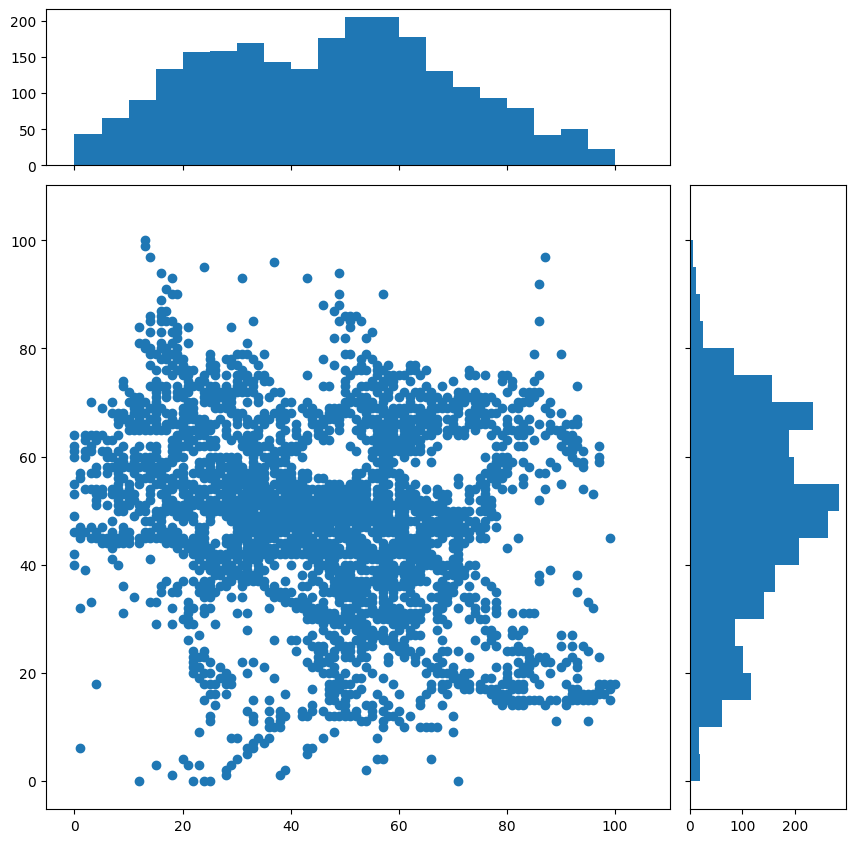

In [37]:
x, y = df_dedup.Latitude.copy(), df_dedup.Longitude.copy()

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 5
    lim = (int(upper/binwidth) + 1) * binwidth

    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

# Start with a square Figure.
fig = plt.figure(figsize=(10, 10))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# fig.set_facecolor('grey')
# ax.set_facecolor('grey')
# ax_histx.set_facecolor('grey')
# ax_histy.set_facecolor('grey')
# Draw the scatter plot and marginals.
scatter_hist(x, y, ax, ax_histx, ax_histy)

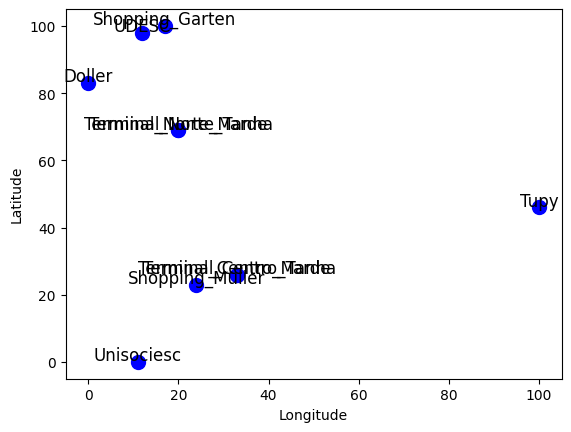

In [48]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the coordinates as a map
# Plot the coordinates as a map
for i, coord in enumerate(df_pis_norm.Latitude):
    ax.plot([df_pis_norm.Longitude[i]], [df_pis_norm.Latitude[i]], 'o', markersize=10, color='blue')
    ax.text(df_pis_norm.Longitude[i], df_pis_norm.Latitude[i] + 0.5, f"{df_pis_norm.Name[i]}", ha="center", fontsize=12)

# Set the axis labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [7]:
coordinates_df = df_dedup[['Latitude', 'Longitude']]
coordinates_df = coordinates_df.reset_index(drop=True)
coordinates_df

,Latitude,Longitude
0,53,77
1,61,75
2,60,68
3,48,50
4,39,51
...,...,...
2384,47,38
2385,43,40
2386,24,54
2387,45,54


In [8]:
# TODO: format `coordinates_df` into this format
map_coordinates = espy.hexagonal_grid(x_size=upper, y_size=upper)
print(f'len(map_coordinates) = {len(map_coordinates)}')
map_coordinates

len(map_coordinates) = 10000


[(0, 0),
 (2, 0),
 (4, 0),
 (6, 0),
 (8, 0),
 (10, 0),
 (12, 0),
 (14, 0),
 (16, 0),
 (18, 0),
 (20, 0),
 (22, 0),
 (24, 0),
 (26, 0),
 (28, 0),
 (30, 0),
 (32, 0),
 (34, 0),
 (36, 0),
 (38, 0),
 (40, 0),
 (42, 0),
 (44, 0),
 (46, 0),
 (48, 0),
 (50, 0),
 (52, 0),
 (54, 0),
 (56, 0),
 (58, 0),
 (60, 0),
 (62, 0),
 (64, 0),
 (66, 0),
 (68, 0),
 (70, 0),
 (72, 0),
 (74, 0),
 (76, 0),
 (78, 0),
 (80, 0),
 (82, 0),
 (84, 0),
 (86, 0),
 (88, 0),
 (90, 0),
 (92, 0),
 (94, 0),
 (96, 0),
 (98, 0),
 (100, 0),
 (102, 0),
 (104, 0),
 (106, 0),
 (108, 0),
 (110, 0),
 (112, 0),
 (114, 0),
 (116, 0),
 (118, 0),
 (120, 0),
 (122, 0),
 (124, 0),
 (126, 0),
 (128, 0),
 (130, 0),
 (132, 0),
 (134, 0),
 (136, 0),
 (138, 0),
 (140, 0),
 (142, 0),
 (144, 0),
 (146, 0),
 (148, 0),
 (150, 0),
 (152, 0),
 (154, 0),
 (156, 0),
 (158, 0),
 (160, 0),
 (162, 0),
 (164, 0),
 (166, 0),
 (168, 0),
 (170, 0),
 (172, 0),
 (174, 0),
 (176, 0),
 (178, 0),
 (180, 0),
 (182, 0),
 (184, 0),
 (186, 0),
 (188, 0),
 (190, 0),

In [9]:
for coordinates in map_coordinates:
    base_station = espy.BaseStation()
    base_station.coordinates = coordinates
    base_station.wireless_delay = 1

    network_switch = espy.sample_switch()
    base_station._connect_to_network_switch(network_switch=network_switch)

In [10]:
topology = espy.partially_connected_hexagonal_mesh(
    network_nodes=espy.NetworkSwitch.all(),
    link_specifications=[
        # {"number_of_objects": 88803, "delay": 1, "bandwidth": 10}
        {"number_of_objects": 29601, "delay": 1, "bandwidth": 10}
    ]
)

In [11]:
def sgi_rackable_c2112_4g10() -> object:
    """Creates an EdgeServer object according to XXXX [TODO].

    Returns:
        edge_server (object): Created EdgeServer object.
    """
    edge_server = espy.EdgeServer()
    # edge_server.model_name = "SGI Rackable C2112-4G10"
    edge_server.model_name = "SGI"

    # Computational capacity (CPU in cores, RAM memory in megabytes, and disk in megabytes)
    edge_server.cpu = 32
    edge_server.memory = 32768
    edge_server.disk = 1048576
    edge_server.mips = 2750

    # Power-related attributes
    edge_server.power_model_parameters = {
        "static_power_percentage": 265 / 1387,
        "max_power_consumption": 1387,
    }

    return edge_server

def proliant_dl360_gen9() -> object:
    """Creates an EdgeServer object according to XXXX [TODO].

    Returns:
        edge_server (object): Created EdgeServer object.
    """
    edge_server = espy.EdgeServer()
    # edge_server.model_name = "HPE ProLiant DL360 Gen9"
    edge_server.model_name = "HPE"

    # Computational capacity (CPU in cores, RAM memory in megabytes, and disk in megabytes)
    edge_server.cpu = 36
    edge_server.memory = 65536
    edge_server.disk = 1048576
    edge_server.mips = 3000

    # Power-related attributes
    edge_server.power_model_parameters = {
        "static_power_percentage": 45 / 276,
        "max_power_consumption": 276,
    }

    return edge_server

def ar585_f1() -> object:
    """Creates an EdgeServer object according to XXXX [TODO].

    Returns:
        edge_server (object): Created EdgeServer object.
    """
    edge_server = espy.EdgeServer()
    # edge_server.model_name = "Acer AR585 F1"
    edge_server.model_name = "Acer"

    # Computational capacity (CPU in cores, RAM memory in megabytes, and disk in megabytes)
    edge_server.cpu = 48
    edge_server.memory = 65536
    edge_server.disk = 1048576
    edge_server.mips = 3500

    # Power-related attributes
    edge_server.power_model_parameters = {
        "static_power_percentage": 127 / 559,
        "max_power_consumption": 559,
    }

    return edge_server

In [12]:
# Creating edge servers
SERVERS_PER_SPEC_TRUSTED_PROVIDERS = 1
SERVERS_PER_SPEC_UNTRUSTED_PROVIDER = 4
provider_specs = [
    {
        "id": 1,
        "edge_server_specs": [
            {"spec": sgi_rackable_c2112_4g10, "number_of_objects": SERVERS_PER_SPEC_TRUSTED_PROVIDERS},
            {"spec": proliant_dl360_gen9, "number_of_objects": SERVERS_PER_SPEC_TRUSTED_PROVIDERS},
            {"spec": ar585_f1, "number_of_objects": SERVERS_PER_SPEC_TRUSTED_PROVIDERS},
        ],
    },
    {
        "id": 2,
        "edge_server_specs": [
            {"spec": sgi_rackable_c2112_4g10, "number_of_objects": SERVERS_PER_SPEC_TRUSTED_PROVIDERS},
            {"spec": proliant_dl360_gen9, "number_of_objects": SERVERS_PER_SPEC_TRUSTED_PROVIDERS},
            {"spec": ar585_f1, "number_of_objects": SERVERS_PER_SPEC_TRUSTED_PROVIDERS},
        ],
    },
    {
        "id": 3,
        "edge_server_specs": [
            {"spec": sgi_rackable_c2112_4g10, "number_of_objects": SERVERS_PER_SPEC_UNTRUSTED_PROVIDER},
            {"spec": proliant_dl360_gen9, "number_of_objects": SERVERS_PER_SPEC_UNTRUSTED_PROVIDER},
            {"spec": ar585_f1, "number_of_objects": SERVERS_PER_SPEC_UNTRUSTED_PROVIDER},
        ],
    },
]

In [13]:
# Creating clusters of network switches based on the number of specified edge servers
number_of_edge_servers = 0
for provider in provider_specs:
    number_of_edge_servers += sum([spec["number_of_objects"] for spec in provider["edge_server_specs"]])
kmeans = KMeans(init="k-means++", n_init=100, n_clusters=number_of_edge_servers, random_state=0, max_iter=1000).fit(
    [switch.coordinates for switch in espy.NetworkSwitch.all()]
)
node_clusters = list(kmeans.labels_)
edge_server_coordinates = []
for centroid in list(kmeans.cluster_centers_):
    node_closest_to_centroid = sorted(
        espy.NetworkSwitch.all(),
        key=lambda switch: np.linalg.norm(np.array(switch.coordinates) - np.array([centroid[0], centroid[1]])),
    )[0]
    edge_server_coordinates.append(node_closest_to_centroid.coordinates)
edge_server_coordinates = random.sample(edge_server_coordinates, len(edge_server_coordinates))

for provider_spec in provider_specs:
    for edge_server_spec in provider_spec["edge_server_specs"]:
        for _ in range(edge_server_spec["number_of_objects"]):
            # Creating the edge server object
            edge_server = edge_server_spec["spec"]()

            # Defining the maximum number of layers that the edge server can pull simultaneously
            edge_server.max_concurrent_layer_downloads = 3

            # Specifying the edge server's power model
            edge_server.power_model = espy.LinearServerPowerModel

            # Edge server's infrastructure provider
            edge_server.infrastructure_provider = provider_spec["id"]

            # Connecting the edge server to a random base station
            # base_stations_without_edge_servers = [bs for bs in BaseStation.all() if len(bs.edge_servers) == 0]
            # base_station = random.sample(base_stations_without_edge_servers, 1)[0]
            base_station: espy.BaseStation = espy.BaseStation.find_by(
                attribute_name="coordinates", attribute_value=edge_server_coordinates[edge_server.id - 1]
            ) # type: ignore
            base_station._connect_to_edge_server(edge_server=edge_server)

In [14]:
# Defining specifications for container images and container registries
container_image_specifications = [
    {
        "name": "alpine",
        "tag": "latest",
        "digest": "sha256:a777c9c66ba177ccfea23f2a216ff6721e78a662cd17019488c417135299cd89",
        "layers": [
            {
                "digest": "sha256:df9b9388f04ad6279a7410b85cedfdcb2208c0a003da7ab5613af71079148139",
                "size": 2,
                "instruction": "ADD file:5d673d25da3a14ce1f6cf",
            }
        ],
        "layers_digests": ["sha256:df9b9388f04ad6279a7410b85cedfdcb2208c0a003da7ab5613af71079148139"],
    },
    {
        "name": "registry",
        "tag": "latest",
        "digest": "sha256:6060f78eda124040cfeb19d2fcc9af417f5ee23dc05d0894fcfe21f24c9cbf9a",
        "layers": [
            {
                "digest": "sha256:df9b9388f04ad6279a7410b85cedfdcb2208c0a003da7ab5613af71079148139",
                "size": 2,
                "instruction": "ADD file:5d673d25da3a14ce1f6cf",
            },
            {
                "digest": "sha256:b6846b9db566bc2ea5e2b0056c49772152c9b7c8f06343efb1ef764b23bb9d96",
                "size": 5,
                "instruction": "/bin/sh -c set -eux; \tversion=",
            },
        ],
        "layers_digests": [
            "sha256:df9b9388f04ad6279a7410b85cedfdcb2208c0a003da7ab5613af71079148139",
            "sha256:b6846b9db566bc2ea5e2b0056c49772152c9b7c8f06343efb1ef764b23bb9d96",
        ],
    },
]

container_registry_specifications = [
    {
        "number_of_objects": 1,
        "cpu_demand": 0,
        "memory_demand": 0,
        "images": [
            {"name": "registry", "tag": "latest"},
            {"name": "alpine", "tag": "latest"},
        ],
    }
]

# Parsing the specifications for container images and container registries
container_registries = espy.create_container_registries(
    container_registry_specifications=container_registry_specifications,
    container_image_specifications=container_image_specifications,
)

# Defining the initial placement for container images and container registries
espy.worst_fit_registries(container_registry_specifications=container_registries, servers=espy.EdgeServer.all())

In [15]:
# Defining user placement and applications/services specifications
def random_user_placement():
    """Method that determines the coordinates of a given user randomly.

    Returns:
        coordinates (tuple): Random user coordinates.
    """
    coordinates = random.choice(map_coordinates)
    return coordinates

In [16]:
# Defining applications/services specifications
application_specifications = [
    {"number_of_objects": 2, "number_of_services": 1},
    {"number_of_objects": 2, "number_of_services": 2},
    {"number_of_objects": 2, "number_of_services": 4},
    {"number_of_objects": 2, "number_of_services": 8},
]

In [17]:
# Defining user delay SLA values (application specs are mirrored for each provider and each application has its own user)
delay_slas = helper.uniform(
    n_items=sum([app_spec["number_of_objects"] for app_spec in application_specifications]) * 2,
    valid_values=[3, 6],
    shuffle_distribution=True,
)

In [18]:
# Defining service demands
service_demand_values = [
    {"cpu": 2, "memory": 2 * 1024},
    {"cpu": 4, "memory": 4 * 1024},
    {"cpu": 8, "memory": 8 * 1024},
    {"cpu": 16, "memory": 16 * 1024},
]

In [19]:
# The number of services considers all service demand combinations multiplied by two (one for each highly trusted provider)
number_of_services = (
    sum([app_spec["number_of_objects"] * app_spec["number_of_services"] for app_spec in application_specifications]) * 2
)
service_demands = helper.uniform(
    n_items=number_of_services,
    valid_values=service_demand_values,
    shuffle_distribution=True,
)

In [20]:
# Defining user/provider trust patterns
providers_trust_patterns = [[2, 1, 0], [1, 2, 0]]

for provider_trust_pattern in providers_trust_patterns:
    for app_spec in application_specifications:
        for _ in range(app_spec["number_of_objects"]):
            app = espy.Application()
            app.provisioned = False

            # Creating the user that access the application
            user = espy.User()

            # Defining user trust on the providers
            user.providers_trust = {1: provider_trust_pattern[0], 2: provider_trust_pattern[1], 3: provider_trust_pattern[2]}

            user.communication_paths[str(app.id)] = None
            user.delays[str(app.id)] = None
            user.delay_slas[str(app.id)] = delay_slas[user.id - 1]

            # Defining user's coordinates and connecting him to a base station
            user.mobility_model = espy.random_mobility
            user._set_initial_position(coordinates=random_user_placement(), number_of_replicates=2)

            # Defining user's access pattern
            espy.CircularDurationAndIntervalAccessPattern(
                user=user,
                app=app,
                start=1,
                duration_values=[float("inf")],
                interval_values=[0],
            )

            # Defining the relationship attributes between the user and the application
            user.applications.append(app)
            app.users.append(user)

            # Defining service privacy requirement values
            service_privacy_requirements = helper.uniform(
                n_items=app_spec["number_of_services"], valid_values=[0, 1, 2], shuffle_distribution=False
            )
            service_privacy_requirements = sorted(service_privacy_requirements)

            # Creating the services that compose the application
            for service_index in range(app_spec["number_of_services"]):
                # Gathering information on the service image based on the specified 'name' and 'tag' parameters
                service_image = next((img for img in espy.ContainerImage.all() if img.name == "alpine"), None)

                # Creating the service object
                service = espy.Service(
                    image_digest=service_image.digest,
                    cpu_demand=None,
                    memory_demand=None,
                    label="Alpine",
                    state=0,
                )
                service.privacy_requirement = service_privacy_requirements[service_index]
                service.cpu_demand = service_demands[service.id - 1]["cpu"]
                service.memory_demand = service_demands[service.id - 1]["memory"]

                # Connecting the application to its new service
                app.connect_to_service(service)

In [21]:
def display_topology(topology: nx.Graph, output_filename: str = "topology"):
    # Customizing visual representation of topology
    positions = {}
    labels = {}
    colors = []
    sizes = []

    # Gathering the coordinates of edge servers
    edge_server_coordinates = [edge_server.coordinates for edge_server in espy.EdgeServer.all()]

    # Defining list of color options
    color_options = []
    for _ in range(espy.EdgeServer.count()):
        color_options.append([random.random(), random.random(), random.random()])

    for node in topology.nodes():
        positions[node] = node.coordinates
        labels[node] = node.id
        node_size = 500 if any(user.coordinates == node.coordinates for user in espy.User.all()) else 100
        sizes.append(node_size)

        if node.coordinates in edge_server_coordinates:
            colors.append("red")
            # colors.append([primary_color_value / 3 for primary_color_value in color_options[node_clusters[node.id - 1]]])
        else:
            colors.append("black")
            # colors.append(color_options[node_clusters[node.id - 1]])

    # Configuring drawing scheme
    nx.draw(
        topology,
        pos=positions,
        node_color=colors,
        node_size=sizes,
        labels=labels,
        font_size=6,
        font_weight="bold",
        font_color="whitesmoke",
    )

    # Saving a topology image in the disk
    plt.savefig(f"{output_filename}.png", dpi=120)

# Application -> provisioned
def application_to_dict(self) -> dict:
    """Method that overrides the way the object is formatted to JSON."
    Returns:
        dict: JSON-friendly representation of the object as a dictionary.
    """
    dictionary = {
        "attributes": {
            "id": self.id,
            "label": self.label,
            "provisioned": self.provisioned,
        },
        "relationships": {
            "services": [{"class": type(service).__name__, "id": service.id} for service in self.services],
            "users": [{"class": type(user).__name__, "id": user.id} for user in self.users],
        },
    }
    return dictionary

# User -> providers_trust
def user_to_dict(self) -> dict:
    """Method that overrides the way User objects are formatted to JSON."

    Returns:
        dict: JSON-friendly representation of the object as a dictionary.
    """
    access_patterns = {}
    for app_id, access_pattern in self.access_patterns.items():
        access_patterns[app_id] = {"class": access_pattern.__class__.__name__, "id": access_pattern.id}

    dictionary = {
        "attributes": {
            "id": self.id,
            "coordinates": self.coordinates,
            "coordinates_trace": self.coordinates_trace,
            "delays": copy.deepcopy(self.delays),
            "delay_slas": copy.deepcopy(self.delay_slas),
            "communication_paths": copy.deepcopy(self.communication_paths),
            "making_requests": copy.deepcopy(self.making_requests),
            "providers_trust": copy.deepcopy(self.providers_trust),
        },
        "relationships": {
            "access_patterns": access_patterns,
            "mobility_model": self.mobility_model.__name__,
            "applications": [{"class": type(app).__name__, "id": app.id} for app in self.applications],
            "base_station": {"class": type(self.base_station).__name__, "id": self.base_station.id},
        },
    }
    return dictionary

# EdgeServer -> infrastructure_provider
def edge_server_to_dict(self) -> dict:
    """Method that overrides the way EdgeServer objects are formatted to JSON."

    Returns:
        dict: JSON-friendly representation of the object as a dictionary.
    """
    dictionary = {
        "attributes": {
            "id": self.id,
            "available": self.available,
            "model_name": self.model_name,
            "cpu": self.cpu,
            "memory": self.memory,
            "disk": self.disk,
            "cpu_demand": self.cpu_demand,
            "memory_demand": self.memory_demand,
            "disk_demand": self.disk_demand,
            "coordinates": self.coordinates,
            "max_concurrent_layer_downloads": self.max_concurrent_layer_downloads,
            "active": self.active,
            "power_model_parameters": self.power_model_parameters,
            "infrastructure_provider": self.infrastructure_provider,
        },
        "relationships": {
            "power_model": self.power_model.__name__ if self.power_model else None,
            "base_station": {"class": type(self.base_station).__name__, "id": self.base_station.id}
            if self.base_station
            else None,
            "network_switch": {"class": type(self.network_switch).__name__, "id": self.network_switch.id}
            if self.network_switch
            else None,
            "services": [{"class": type(service).__name__, "id": service.id} for service in self.services],
            "container_layers": [{"class": type(layer).__name__, "id": layer.id} for layer in self.container_layers],
            "container_images": [{"class": type(image).__name__, "id": image.id} for image in self.container_images],
            "container_registries": [{"class": type(reg).__name__, "id": reg.id} for reg in self.container_registries],
        },
    }
    return dictionary

# Service -> privacy_requirement
def service_to_dict(self) -> dict:
    """Method that overrides the way Service objects are formatted to JSON."

    Returns:
        dict: JSON-friendly representation of the object as a dictionary.
    """
    dictionary = {
        "attributes": {
            "id": self.id,
            "label": self.label,
            "state": self.state,
            "_available": self._available,
            "cpu_demand": self.cpu_demand,
            "memory_demand": self.memory_demand,
            "image_digest": self.image_digest,
            "privacy_requirement": self.privacy_requirement,
        },
        "relationships": {
            "application": {"class": type(self.application).__name__, "id": self.application.id},
            "server": {"class": type(self.server).__name__, "id": self.server.id} if self.server else None,
        },
    }
    return dictionary

In [22]:
# Calculating the network delay between users and edge servers (useful for defining reasonable delay SLAs)
users = []
for user in espy.User.all():
    user_metadata = {"object": user, "all_delays": []}
    edge_servers = []
    for edge_server in espy.EdgeServer.all():
        path = nx.shortest_path(
            G=espy.Topology.first(), source=user.base_station.network_switch, target=edge_server.network_switch, weight="delay"
        )
        user_metadata["all_delays"].append(espy.Topology.first().calculate_path_delay(path=path))
    user_metadata["min_delay"] = min(user_metadata["all_delays"])
    user_metadata["max_delay"] = max(user_metadata["all_delays"])
    user_metadata["avg_delay"] = sum(user_metadata["all_delays"]) / len(user_metadata["all_delays"])
    user_metadata["delays"] = {}
    for delay in sorted(list(set(user_metadata["all_delays"]))):
        user_metadata["delays"][delay] = user_metadata["all_delays"].count(delay)

    users.append(user_metadata)

print("\n\n==== NETWORK DISTANCE (DELAY) BETWEEN USERS AND EDGE SERVERS ====")
for user_metadata in users:
    user_attrs = {
        "object": user_metadata["object"],
        "sla": user_metadata["object"].delay_slas[str(user_metadata["object"].applications[0].id)],
        "min": user_metadata["min_delay"],
        "max": user_metadata["max_delay"],
        "avg": round(user_metadata["avg_delay"]),
        "delays": user_metadata["delays"],
    }
    print(f"{user_attrs}")
    if user_attrs["min"] > user_attrs["sla"]:
        print(f"\n\nWARNING: {user_attrs['object']} delay SLA is not achievable!\n\n")



==== NETWORK DISTANCE (DELAY) BETWEEN USERS AND EDGE SERVERS ====
{'object': User_1, 'sla': 6, 'min': 14, 'max': 66, 'avg': 41, 'delays': {14: 1, 19: 1, 20: 2, 29: 1, 34: 1, 35: 1, 37: 1, 47: 4, 50: 2, 51: 1, 52: 1, 65: 1, 66: 1}}




{'object': User_2, 'sla': 3, 'min': 10, 'max': 67, 'avg': 39, 'delays': {10: 1, 12: 1, 25: 1, 28: 1, 30: 2, 33: 1, 37: 1, 38: 2, 40: 1, 47: 1, 48: 1, 50: 1, 51: 1, 55: 1, 62: 1, 67: 1}}




{'object': User_3, 'sla': 6, 'min': 8, 'max': 97, 'avg': 53, 'delays': {8: 1, 15: 1, 24: 1, 32: 1, 38: 1, 40: 1, 42: 1, 43: 1, 49: 1, 60: 1, 64: 1, 71: 2, 72: 1, 73: 1, 79: 1, 82: 1, 97: 1}}




{'object': User_4, 'sla': 3, 'min': 11, 'max': 74, 'avg': 44, 'delays': {11: 1, 14: 1, 25: 1, 27: 1, 29: 1, 31: 2, 43: 1, 46: 1, 49: 1, 50: 1, 58: 2, 59: 2, 60: 1, 68: 1, 74: 1}}




{'object': User_5, 'sla': 3, 'min': 17, 'max': 98, 'avg': 59, 'delays': {17: 2, 33: 1, 35: 1, 48: 1, 49: 1, 50: 2, 54: 1, 61: 1, 65: 1, 79: 1, 82: 2, 83: 2, 84: 1, 98: 1}}




{'object': User_6, 

In [23]:
# Calculating the infrastructure occupation and information about the services
edge_server_cpu_capacity = 0
edge_server_memory_capacity = 0
service_cpu_demand = 0
service_memory_demand = 0

for edge_server in espy.EdgeServer.all():
    edge_server_cpu_capacity += edge_server.cpu
    edge_server_memory_capacity += edge_server.memory

for service in espy.Service.all():
    service_cpu_demand += service.cpu_demand
    service_memory_demand += service.memory_demand

overall_cpu_occupation = round((service_cpu_demand / edge_server_cpu_capacity) * 100, 1)
overall_memory_occupation = round((service_memory_demand / edge_server_memory_capacity) * 100, 1)

print("\n\n==== INFRASTRUCTURE OCCUPATION OVERVIEW ====")
print(f"Edge Servers: {espy.EdgeServer.count()}")
print(f"\tCPU Capacity: {edge_server_cpu_capacity}")
print(f"\tRAM Capacity: {edge_server_memory_capacity}")
print(f"Services: {espy.Service.count()}")
print(f"\tCPU Demand: {service_cpu_demand}")
print(f"\t\t[Privacy Requirement = 0] {sum([s.cpu_demand for s in espy.Service.all() if s.privacy_requirement == 0])}")
print(f"\t\t[Privacy Requirement = 1] {sum([s.cpu_demand for s in espy.Service.all() if s.privacy_requirement == 1])}")
print(f"\t\t[Privacy Requirement = 2] {sum([s.cpu_demand for s in espy.Service.all() if s.privacy_requirement == 2])}")
print(f"\tRAM Demand: {service_memory_demand}")
print(f"\t\t[Privacy Requirement = 0] {sum([s.memory_demand for s in espy.Service.all() if s.privacy_requirement == 0])}")
print(f"\t\t[Privacy Requirement = 1] {sum([s.memory_demand for s in espy.Service.all() if s.privacy_requirement == 1])}")
print(f"\t\t[Privacy Requirement = 2] {sum([s.memory_demand for s in espy.Service.all() if s.privacy_requirement == 2])}")
print("Overall Occupation")
print(f"\tCPU: {overall_cpu_occupation}%")
print(f"\tRAM: {overall_memory_occupation}%")



==== INFRASTRUCTURE OCCUPATION OVERVIEW ====
Edge Servers: 18
	CPU Capacity: 696
	RAM Capacity: 983040
Services: 60
	CPU Demand: 450
		[Privacy Requirement = 0] 90
		[Privacy Requirement = 1] 130
		[Privacy Requirement = 2] 230
	RAM Demand: 460800
		[Privacy Requirement = 0] 92160
		[Privacy Requirement = 1] 133120
		[Privacy Requirement = 2] 235520
Overall Occupation
	CPU: 64.7%
	RAM: 46.9%


In [24]:
# Calculating the occupation of each infrastructure provider
print("==== INFRASTRUCTURE PROVIDERS OVERVIEW ====")
for provider_id in range(1, len(provider_specs) + 1):
    provider_edge_servers = [s for s in espy.EdgeServer.all() if s.infrastructure_provider == provider_id]

    users_with_trust0 = [user for user in espy.User.all() if user.providers_trust[provider_id] == 0]
    users_with_trust1 = [user for user in espy.User.all() if user.providers_trust[provider_id] == 1]
    users_with_trust2 = [user for user in espy.User.all() if user.providers_trust[provider_id] == 2]

    demand_trust0 = sum(
        [sum([s.cpu_demand for s in u.applications[0].services if s.privacy_requirement == 0]) for u in users_with_trust0]
    )
    demand_trust1 = sum(
        [sum([s.cpu_demand for s in u.applications[0].services if s.privacy_requirement == 0]) for u in users_with_trust1]
    )
    demand_trust2 = sum(
        [sum([s.cpu_demand for s in u.applications[0].services if s.privacy_requirement == 0]) for u in users_with_trust2]
    )

    print(f"=== Provider {provider_id} ===")
    print(f"Overall CPU: {sum([s.cpu for s in provider_edge_servers])}")
    print(f"Overall RAM: {sum([s.memory for s in provider_edge_servers])}")
    print(f"\tUsers with trust 0: {len(users_with_trust0)}. CPU Demand: {demand_trust0}")
    print(f"\tUsers with trust 1: {len(users_with_trust1)}. CPU Demand: {demand_trust1}")
    print(f"\tUsers with trust 2: {len(users_with_trust2)}. CPU Demand: {demand_trust2}\n")

# Exporting scenario
espy.Application._to_dict = application_to_dict
espy.User._to_dict = user_to_dict
espy.EdgeServer._to_dict = edge_server_to_dict
espy.Service._to_dict = service_to_dict
espy.ComponentManager.export_scenario(save_to_file=True, file_name="../../datasets/dataset_test") # file_name is prepended with "datasets/"

==== INFRASTRUCTURE PROVIDERS OVERVIEW ====
=== Provider 1 ===
Overall CPU: 116
Overall RAM: 163840
	Users with trust 0: 0. CPU Demand: 0
	Users with trust 1: 8. CPU Demand: 54
	Users with trust 2: 8. CPU Demand: 36

=== Provider 2 ===
Overall CPU: 116
Overall RAM: 163840
	Users with trust 0: 0. CPU Demand: 0
	Users with trust 1: 8. CPU Demand: 36
	Users with trust 2: 8. CPU Demand: 54

=== Provider 3 ===
Overall CPU: 464
Overall RAM: 655360
	Users with trust 0: 16. CPU Demand: 90
	Users with trust 1: 0. CPU Demand: 0
	Users with trust 2: 0. CPU Demand: 0



{'NetworkSwitch': [{'attributes': {'id': 1,
    'coordinates': (0, 0),
    'active': True,
    'power_model_parameters': {'chassis_power': 60,
     'ports_power_consumption': {'125': 1, '12.5': 0.3}}},
   'relationships': {'power_model': 'ConteratoNetworkPowerModel',
    'edge_servers': [],
    'links': [],
    'base_station': {'class': 'BaseStation', 'id': 1}}},
  {'attributes': {'id': 2,
    'coordinates': (2, 0),
    'active': True,
    'power_model_parameters': {'chassis_power': 60,
     'ports_power_consumption': {'125': 1, '12.5': 0.3}}},
   'relationships': {'power_model': 'ConteratoNetworkPowerModel',
    'edge_servers': [],
    'links': [],
    'base_station': {'class': 'BaseStation', 'id': 2}}},
  {'attributes': {'id': 3,
    'coordinates': (4, 0),
    'active': True,
    'power_model_parameters': {'chassis_power': 60,
     'ports_power_consumption': {'125': 1, '12.5': 0.3}}},
   'relationships': {'power_model': 'ConteratoNetworkPowerModel',
    'edge_servers': [],
    'links

In [25]:
display_topology(espy.Topology.first())

TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

In [ ]:
def resource_management_algorithm(parameters):
    # We can always call the 'all()' method to get a list with all created instances of a given class
    for service in espy.Service.all():
        # We don't want to migrate services are are already being migrated
        if service.server == None and not service.being_provisioned:
            # Let's iterate over the list of edge servers to find a suitable host for our service
            for edge_server in espy.EdgeServer.all():
                # We must check if the edge server has enough resources to host the service
                if edge_server.has_capacity_to_host(service=service):
                    # Start provisioning the service in the edge server
                    service.provision(target_server=edge_server)
                    # After start migrating the service we can move on to the next service
                    break

def stopping_criterion(model: object):
    # Defining a variable that will help us to count the number of services successfully provisioned within the infrastructure
    provisioned_services = 0
    # Iterating over the list of services to count the number of services provisioned within the infrastructure
    for service in espy.Service.all():
        # Initially, services are not hosted by any server (i.e., their "server" attribute is None).
        # Once that value changes, we know that it has been successfully provisioned inside an edge server.
        if service.server != None:
            provisioned_services += 1
    # As EdgeSimPy will halt the simulation whenever this function returns True, its output will be a boolean expression
    # that checks if the number of provisioned services equals to the number of services spawned in our simulation
    return provisioned_services == espy.Service.count()

In [ ]:
simulator = espy.Simulator(
    dump_interval=5,
    tick_duration=1,
    tick_unit="seconds",
    stopping_criterion=stopping_criterion,
    resource_management_algorithm=resource_management_algorithm,
)

simulator.initialize(input_file="../datasets/dataset_test.json")

simulator.run_model()